## Stock Market Model Training and Evaluation
### CS 5805 Machine Learning - Project Midway

Train and evaluate baseline models (Logistic Regression, Random Forest, SVM) and LSTM model for stock market direction prediction


Inputs (generated from `1_data_cleaning.ipynb`):

- data/processed/train.csv
- data/processed/val.csv
- data/processed/test.csv

### 1. Setup & Configuration

In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("All libraries imported successfully")

All libraries imported successfully


In [159]:
# Paths
PROCESSED_DATA_DIR = Path('../data/processed')
MODELS_DIR = Path('../models')
OUTPUTS_DIR = Path('../outputs')
FIGURES_DIR = OUTPUTS_DIR / 'figures'
METRICS_DIR = OUTPUTS_DIR / 'metrics'

# Create directories
MODELS_DIR.mkdir(exist_ok=True)
OUTPUTS_DIR.mkdir(exist_ok=True)
FIGURES_DIR.mkdir(exist_ok=True)
METRICS_DIR.mkdir(exist_ok=True)

# Features to use for prediction
FEATURE_COLUMNS = [
    'Open', 'High', 'Low', 'Close',
    'Volume','SMA_5', 'SMA_10',
    'SMA_20', 'EMA_12', 'EMA_26',
    'MACD', 'MACD_Signal', 'RSI',
    'Momentum_5', 'Momentum_10',
    'Momentum_20', 'Volatility_5',
    'Volatility_20', 'Volume_SMA_5',
    'Volume_Ratio', 'High_Low_Range',
    'Close_Position', 'Close_Lag1',
    'Close_Lag5', 'Volume_Lag1',
    'Close_vs_SMA5', 'Close_vs_SMA20'
]
TARGET_COLUMN = 'Label'

# LSTM hyperparameters
LSTM_CONFIG = {
    'sequence_length': 10,
    'hidden_size': 32,
    'num_layers': 1,
    'dropout': 0.3,
    'learning_rate': 0.0005,
    'batch_size': 32,
    'num_epochs': 100,
    'patience': 10
}

print("Configuration:")
print(f"  Data directory: {PROCESSED_DATA_DIR}")
print(f"  Models directory: {MODELS_DIR}")
print(f"  Outputs directory: {OUTPUTS_DIR}")
print(f"  Features: {FEATURE_COLUMNS}")
print(f"  Target: {TARGET_COLUMN}")
print(f"\nLSTM Configuration:")
for key, value in LSTM_CONFIG.items():
    print(f"  {key}: {value}")

Configuration:
  Data directory: ..\data\processed
  Models directory: ..\models
  Outputs directory: ..\outputs
  Features: ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_5', 'SMA_10', 'SMA_20', 'EMA_12', 'EMA_26', 'MACD', 'MACD_Signal', 'RSI', 'Momentum_5', 'Momentum_10', 'Momentum_20', 'Volatility_5', 'Volatility_20', 'Volume_SMA_5', 'Volume_Ratio', 'High_Low_Range', 'Close_Position', 'Close_Lag1', 'Close_Lag5', 'Volume_Lag1', 'Close_vs_SMA5', 'Close_vs_SMA20']
  Target: Label

LSTM Configuration:
  sequence_length: 10
  hidden_size: 32
  num_layers: 1
  dropout: 0.3
  learning_rate: 0.0005
  batch_size: 32
  num_epochs: 100
  patience: 10


### 2. Load Processed Data

In [160]:
# Load train, validation, and test sets
print("Loading processed data:\n")

train_df = pd.read_csv(PROCESSED_DATA_DIR / 'train.csv')
val_df = pd.read_csv(PROCESSED_DATA_DIR / 'val.csv')
test_df = pd.read_csv(PROCESSED_DATA_DIR / 'test.csv')

# Convert Date column to datetime
for df in [train_df, val_df, test_df]:
    df['Date'] = pd.to_datetime(df['Date'])

print(f"Train set: {len(train_df):,} samples")
print(f"  Date range: {train_df['Date'].min().date()} to {train_df['Date'].max().date()}")
print(f"  Label distribution: {train_df[TARGET_COLUMN].value_counts().to_dict()}")

print(f"\nValidation set: {len(val_df):,} samples")
print(f"  Date range: {val_df['Date'].min().date()} to {val_df['Date'].max().date()}")
print(f"  Label distribution: {val_df[TARGET_COLUMN].value_counts().to_dict()}")

print(f"\nTest set: {len(test_df):,} samples")
print(f"  Date range: {test_df['Date'].min().date()} to {test_df['Date'].max().date()}")
print(f"  Label distribution: {test_df[TARGET_COLUMN].value_counts().to_dict()}")

print(f"\nData loaded successfully")

Loading processed data:

Train set: 12,798 samples
  Date range: 2010-07-27 to 2015-08-25
  Label distribution: {1: 6617, 0: 6181}

Validation set: 2,580 samples
  Date range: 2015-09-24 to 2016-09-30
  Label distribution: {1: 1357, 0: 1223}

Test set: 2,600 samples
  Date range: 2016-10-31 to 2017-11-09
  Label distribution: {1: 1416, 0: 1184}

Data loaded successfully


In [161]:
# Data inspection
print("\nSample of training data:")
display(train_df.head(10))

print("\nData types:")
display(train_df.dtypes)

print("\nBasic statistics:")
display(train_df[FEATURE_COLUMNS + [TARGET_COLUMN]].describe())


Sample of training data:


,Date,Open,High,Low,Close,Volume,OpenInt,Stock,Daily_Return,price_change_pct,...,Volatility_20,Volume_SMA_5,Volume_Ratio,High_Low_Range,Close_Position,Close_Lag1,Close_Lag5,Volume_Lag1,Close_vs_SMA5,Close_vs_SMA20
0,2010-07-27,33.382,33.910,33.336,33.820,161964837,0,AAPL,1.855198,1.855198,...,0.653236,187361291.0,0.864452,0.574,0.843206,33.204,32.260,116242953.0,0.6122,1.25775
1,2010-07-28,33.768,34.065,33.329,33.419,144771462,0,AAPL,-1.185689,-1.185689,...,0.679142,150279463.4,0.963348,0.736,0.122283,33.820,32.556,161964837.0,0.0386,0.82610
2,2010-07-29,33.387,33.634,32.797,33.055,179422840,0,AAPL,-1.089201,-1.089201,...,0.680416,150208608.8,1.194491,0.837,0.308244,33.419,33.171,144771462.0,-0.3022,0.41995
3,2010-07-30,32.750,33.257,32.643,32.944,124974375,0,AAPL,-0.335804,-0.335804,...,0.655726,145475293.4,0.859076,0.614,0.490228,33.055,33.288,179422840.0,-0.3444,0.25290
4,2010-08-02,33.352,33.627,33.247,33.532,118919147,0,AAPL,1.784847,1.784847,...,0.630522,146010532.2,0.814456,0.380,0.750000,32.944,33.204,124974375.0,0.1780,0.74545
5,2010-08-03,33.532,33.712,33.223,33.544,116136901,0,AAPL,0.035787,0.035787,...,0.610881,136844945.0,0.848675,0.489,0.656442,33.532,33.820,118919147.0,0.2452,0.67235
6,2010-08-04,33.649,33.843,33.337,33.677,117191873,0,AAPL,0.396494,0.396494,...,0.634926,131329027.2,0.892353,0.506,0.671937,33.544,33.419,116136901.0,0.3266,0.77775
7,2010-08-05,33.485,33.703,33.366,33.513,80608260,0,AAPL,-0.486979,-0.486979,...,0.648976,111566111.2,0.722516,0.337,0.436202,33.677,33.055,117191873.0,0.0710,0.59070
8,2010-08-06,33.257,33.486,32.991,33.307,123996524,0,AAPL,-0.614687,-0.614687,...,0.650692,111370541.0,1.113369,0.495,0.638384,33.513,32.944,80608260.0,-0.2076,0.38170
9,2010-08-09,33.486,33.572,33.242,33.520,84312659,0,AAPL,0.639505,0.639505,...,0.664174,104449243.4,0.807212,0.330,0.842424,33.307,33.532,123996524.0,0.0078,0.56620



Data types:


Date                datetime64[ns]
Open                       float64
High                       float64
Low                        float64
Close                      float64
Volume                       int64
OpenInt                      int64
Stock                       object
Daily_Return               float64
price_change_pct           float64
Price_Change               float64
Label                        int64
SMA_5                      float64
SMA_10                     float64
SMA_20                     float64
EMA_12                     float64
EMA_26                     float64
MACD                       float64
MACD_Signal                float64
RSI                        float64
Momentum_5                 float64
Momentum_10                float64
Momentum_20                float64
Volatility_5               float64
Volatility_20              float64
Volume_SMA_5               float64
Volume_Ratio               float64
High_Low_Range             float64
Close_Position      


Basic statistics:


,Open,High,Low,Close,Volume,SMA_5,SMA_10,SMA_20,EMA_12,EMA_26,...,Volume_SMA_5,Volume_Ratio,High_Low_Range,Close_Position,Close_Lag1,Close_Lag5,Volume_Lag1,Close_vs_SMA5,Close_vs_SMA20,Label
count,12798.000000,12798.000000,12798.000000,12798.000000,1.279800e+04,12798.000000,12798.000000,12798.000000,12798.000000,12798.000000,...,1.279800e+04,12798.000000,12798.000000,12798.000000,12798.000000,12798.000000,1.279800e+04,12798.000000,12798.000000,12798.000000
mean,117.126498,118.243690,115.942787,117.119464,2.546661e+07,116.935419,116.676568,116.146996,116.567006,115.843844,...,2.547449e+07,1.006011,2.300903,0.516871,117.030639,116.633418,2.546682e+07,0.184044,0.972468,0.517034
std,132.241549,133.427694,130.905830,132.167483,3.869298e+07,131.931625,131.580036,130.860412,131.398936,130.440939,...,3.648775e+07,0.309831,3.243316,0.299877,132.071422,131.594406,3.869519e+07,3.491998,7.577617,0.499729
min,15.592000,16.142000,8.030000,15.556000,1.186140e+05,15.966400,16.204200,16.506300,16.335552,16.623194,...,2.271204e+05,0.235234,0.111000,0.000000,15.556000,15.556000,1.186140e+05,-46.768000,-61.594500,0.000000
25%,41.397750,41.659500,40.991000,41.374500,5.455643e+06,41.311250,41.103925,40.671462,41.084658,40.851796,...,5.842980e+06,0.811574,0.547000,0.252987,41.308250,41.062500,5.455643e+06,-0.429000,-0.787000,0.000000
50%,59.575500,59.893500,59.094500,59.602500,1.074674e+07,59.396200,59.172500,58.893900,59.087956,58.667466,...,1.109412e+07,0.956275,0.867000,0.524002,59.506500,59.263000,1.074674e+07,0.084100,0.383900,1.000000
75%,118.265000,119.310000,116.517500,118.077500,2.745083e+07,118.324500,118.955000,117.505000,118.633816,116.457965,...,2.775233e+07,1.141695,2.630000,0.782298,118.025000,117.460000,2.745083e+07,0.629450,1.648762,1.000000
max,699.580000,713.330000,691.620000,699.620000,5.192501e+08,691.528000,684.154000,673.954000,681.573070,661.870994,...,2.883091e+08,3.808311,51.240000,1.000000,699.620000,699.620000,5.192501e+08,91.366000,134.546000,1.000000


### 3. Prepare Data for Baseline Models

In [162]:
# Extract features and labels for baseline models
print("Preparing data for baseline models:\n")

X_train = train_df[FEATURE_COLUMNS].values
y_train = train_df[TARGET_COLUMN].values

X_val = val_df[FEATURE_COLUMNS].values
y_val = val_df[TARGET_COLUMN].values

X_test = test_df[FEATURE_COLUMNS].values
y_test = test_df[TARGET_COLUMN].values

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"\nData prepared and scaled for baseline models")

Preparing data for baseline models:

X_train shape: (12798, 27)
y_train shape: (12798,)
X_val shape: (2580, 27)
y_val shape: (2580,)
X_test shape: (2600, 27)
y_test shape: (2600,)

Data prepared and scaled for baseline models


### 4. Baseline 1: Logistic Regression

In [163]:
print("Training Logistic Regression:")

# Train
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred_lr = lr_model.predict(X_train_scaled)
y_val_pred_lr = lr_model.predict(X_val_scaled)
y_test_pred_lr = lr_model.predict(X_test_scaled)

# Evaluation metrics
lr_metrics = {
    'train_accuracy': accuracy_score(y_train, y_train_pred_lr),
    'val_accuracy': accuracy_score(y_val, y_val_pred_lr),
    'test_accuracy': accuracy_score(y_test, y_test_pred_lr),
    'test_precision': precision_score(y_test, y_test_pred_lr),
    'test_recall': recall_score(y_test, y_test_pred_lr),
    'test_f1': f1_score(y_test, y_test_pred_lr),
    'test_auc': roc_auc_score(y_test, lr_model.predict_proba(X_test_scaled)[:, 1])
}

# Print results
print("\nLogistic Regression Results:")
print(f"  Train Accuracy: {lr_metrics['train_accuracy']:.4f}")
print(f"  Val Accuracy:   {lr_metrics['val_accuracy']:.4f}")
print(f"  Test Accuracy:  {lr_metrics['test_accuracy']:.4f}")
print(f"  Test Precision: {lr_metrics['test_precision']:.4f}")
print(f"  Test Recall:    {lr_metrics['test_recall']:.4f}")
print(f"  Test F1 Score:  {lr_metrics['test_f1']:.4f}")
print(f"  Test AUC:       {lr_metrics['test_auc']:.4f}")

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred_lr, target_names=['Down', 'Up']))

Training Logistic Regression:

Logistic Regression Results:
  Train Accuracy: 0.5286
  Val Accuracy:   0.5271
  Test Accuracy:  0.5158
  Test Precision: 0.5425
  Test Recall:    0.7083
  Test F1 Score:  0.6144
  Test AUC:       0.4838

Classification Report (Test Set):
              precision    recall  f1-score   support

        Down       0.45      0.29      0.35      1184
          Up       0.54      0.71      0.61      1416

    accuracy                           0.52      2600
   macro avg       0.50      0.50      0.48      2600
weighted avg       0.50      0.52      0.49      2600



### 5. Baseline 2: Random Forest

In [164]:
print("Training Random Forest:")

# Train
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)  # Random Forest doesn't need scaling

# Predictions
y_train_pred_rf = rf_model.predict(X_train)
y_val_pred_rf = rf_model.predict(X_val)
y_test_pred_rf = rf_model.predict(X_test)

# Evaluation metrics
rf_metrics = {
    'train_accuracy': accuracy_score(y_train, y_train_pred_rf),
    'val_accuracy': accuracy_score(y_val, y_val_pred_rf),
    'test_accuracy': accuracy_score(y_test, y_test_pred_rf),
    'test_precision': precision_score(y_test, y_test_pred_rf),
    'test_recall': recall_score(y_test, y_test_pred_rf),
    'test_f1': f1_score(y_test, y_test_pred_rf),
    'test_auc': roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])
}

# Print results
print("\nRandom Forest Results:")
print(f"  Train Accuracy: {rf_metrics['train_accuracy']:.4f}")
print(f"  Val Accuracy:   {rf_metrics['val_accuracy']:.4f}")
print(f"  Test Accuracy:  {rf_metrics['test_accuracy']:.4f}")
print(f"  Test Precision: {rf_metrics['test_precision']:.4f}")
print(f"  Test Recall:    {rf_metrics['test_recall']:.4f}")
print(f"  Test F1 Score:  {rf_metrics['test_f1']:.4f}")
print(f"  Test AUC:       {rf_metrics['test_auc']:.4f}")

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred_rf, target_names=['Down', 'Up']))

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': FEATURE_COLUMNS,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
display(feature_importance)

Training Random Forest:

Random Forest Results:
  Train Accuracy: 0.7600
  Val Accuracy:   0.5027
  Test Accuracy:  0.5046
  Test Precision: 0.5414
  Test Recall:    0.5911
  Test F1 Score:  0.5652
  Test AUC:       0.4908

Classification Report (Test Set):
              precision    recall  f1-score   support

        Down       0.45      0.40      0.42      1184
          Up       0.54      0.59      0.57      1416

    accuracy                           0.50      2600
   macro avg       0.50      0.50      0.49      2600
weighted avg       0.50      0.50      0.50      2600


Feature Importance:


,Feature,Importance
19,Volume_Ratio,0.065760
13,Momentum_5,0.054651
21,Close_Position,0.051390
24,Volume_Lag1,0.048244
14,Momentum_10,0.046973
15,Momentum_20,0.046114
17,Volatility_20,0.045108
12,RSI,0.044793
11,MACD_Signal,0.043508
4,Volume,0.043058


### 6. Baseline 3: Support Vector Machine

In [165]:
print("Training Support Vector Machine (SVM):")

# Train
print("Training SVM... (may take a minute or so)")
svm_model = SVC(kernel='rbf', C=1.0, probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred_svm = svm_model.predict(X_train_scaled)
y_val_pred_svm = svm_model.predict(X_val_scaled)
y_test_pred_svm = svm_model.predict(X_test_scaled)

# Evaluation metrics
svm_metrics = {
    'train_accuracy': accuracy_score(y_train, y_train_pred_svm),
    'val_accuracy': accuracy_score(y_val, y_val_pred_svm),
    'test_accuracy': accuracy_score(y_test, y_test_pred_svm),
    'test_precision': precision_score(y_test, y_test_pred_svm),
    'test_recall': recall_score(y_test, y_test_pred_svm),
    'test_f1': f1_score(y_test, y_test_pred_svm),
    'test_auc': roc_auc_score(y_test, svm_model.predict_proba(X_test_scaled)[:, 1])
}

# Print results
print("\nSVM Results:")
print(f"  Train Accuracy: {svm_metrics['train_accuracy']:.4f}")
print(f"  Val Accuracy:   {svm_metrics['val_accuracy']:.4f}")
print(f"  Test Accuracy:  {svm_metrics['test_accuracy']:.4f}")
print(f"  Test Precision: {svm_metrics['test_precision']:.4f}")
print(f"  Test Recall:    {svm_metrics['test_recall']:.4f}")
print(f"  Test F1 Score:  {svm_metrics['test_f1']:.4f}")
print(f"  Test AUC:       {svm_metrics['test_auc']:.4f}")

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred_svm, target_names=['Down', 'Up']))

Training Support Vector Machine (SVM):
Training SVM... (may take a minute or so)

SVM Results:
  Train Accuracy: 0.5554
  Val Accuracy:   0.5182
  Test Accuracy:  0.5208
  Test Precision: 0.5459
  Test Recall:    0.7140
  Test F1 Score:  0.6187
  Test AUC:       0.4961

Classification Report (Test Set):
              precision    recall  f1-score   support

        Down       0.46      0.29      0.36      1184
          Up       0.55      0.71      0.62      1416

    accuracy                           0.52      2600
   macro avg       0.50      0.50      0.49      2600
weighted avg       0.51      0.52      0.50      2600



### 7. Prepare Data for LSTM Model

In [166]:
print("Preparing Data for LSTM:")

def create_sequences(data, seq_length):
    """
    Create sequences for LSTM training.
    
    Args:
        data: DataFrame with features/labels
        seq_length: Length of input sequences
    
    Returns:
        X: Array of sequences (num_sequences, seq_length, num_features)
        y: Array of labels (num_sequences,)
    """
    X, y = [], []
    
    # Group by stock to maintain temporal order
    for stock in data['Stock'].unique():
        stock_data = data[data['Stock'] == stock].sort_values('Date')
        
        features = stock_data[FEATURE_COLUMNS].values
        labels = stock_data[TARGET_COLUMN].values
        
        # Create sequences
        for i in range(len(stock_data) - seq_length):
            X.append(features[i:i+seq_length])
            y.append(labels[i+seq_length])
    
    return np.array(X), np.array(y)

# Create sequences
seq_length = LSTM_CONFIG['sequence_length']
print(f"Creating sequences with length {seq_length}...\n")

X_train_seq, y_train_seq = create_sequences(train_df, seq_length)
X_val_seq, y_val_seq = create_sequences(val_df, seq_length)
X_test_seq, y_test_seq = create_sequences(test_df, seq_length)

print(f"X_train_seq shape: {X_train_seq.shape}")
print(f"y_train_seq shape: {y_train_seq.shape}")
print(f"X_val_seq shape: {X_val_seq.shape}")
print(f"y_val_seq shape: {y_val_seq.shape}")
print(f"X_test_seq shape: {X_test_seq.shape}")
print(f"y_test_seq shape: {y_test_seq.shape}")

# Normalize sequences
scaler_lstm = StandardScaler()
X_train_seq_scaled = scaler_lstm.fit_transform(X_train_seq.reshape(-1, len(FEATURE_COLUMNS))).reshape(X_train_seq.shape)
X_val_seq_scaled = scaler_lstm.transform(X_val_seq.reshape(-1, len(FEATURE_COLUMNS))).reshape(X_val_seq.shape)
X_test_seq_scaled = scaler_lstm.transform(X_test_seq.reshape(-1, len(FEATURE_COLUMNS))).reshape(X_test_seq.shape)

print(f"\nSequences created and normalized")

Preparing Data for LSTM:
Creating sequences with length 10...

X_train_seq shape: (12698, 10, 27)
y_train_seq shape: (12698,)
X_val_seq shape: (2480, 10, 27)
y_val_seq shape: (2480,)
X_test_seq shape: (2500, 10, 27)
y_test_seq shape: (2500,)

Sequences created and normalized


In [167]:
# Create PyTorch datasets and dataloaders
class StockDataset(Dataset):
    """Custom Dataset for stock sequences."""
    
    def __init__(self, sequences, labels):
        self.sequences = torch.FloatTensor(sequences)
        self.labels = torch.LongTensor(labels)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

# Create datasets
train_dataset = StockDataset(X_train_seq_scaled, y_train_seq)
val_dataset = StockDataset(X_val_seq_scaled, y_val_seq)
test_dataset = StockDataset(X_test_seq_scaled, y_test_seq)

# Create dataloaders
batch_size = LSTM_CONFIG['batch_size']
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Created DataLoaders with batch size {batch_size}")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Created DataLoaders with batch size 32
Train batches: 397
Val batches: 78
Test batches: 79


### 8. Define LSTM Model

In [168]:
class LSTMModel(nn.Module):
    """LSTM model for binary classification."""
    
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.2):
        super(LSTMModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)
        
        # Fully connected output layer
        self.fc = nn.Linear(hidden_size, 2)  # Binary classification (Up/Down)
    
    def forward(self, x):
        # x shape: (batch_size, seq_length, input_size)
        
        # LSTM forward pass
        lstm_out, (h_n, c_n) = self.lstm(x)
        
        # Use the last hidden state
        last_hidden = lstm_out[:, -1, :]
        
        # Apply dropout
        out = self.dropout(last_hidden)
        
        # Fully connected layer
        out = self.fc(out)
        
        return out

# Initialize model
input_size = len(FEATURE_COLUMNS)
hidden_size = LSTM_CONFIG['hidden_size']
num_layers = LSTM_CONFIG['num_layers']
dropout = LSTM_CONFIG['dropout']

model = LSTMModel(input_size, hidden_size, num_layers, dropout)

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(f"LSTM Model Architecture:")
print(model)
print(f"\nDevice: {device}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

LSTM Model Architecture:
LSTMModel(
  (lstm): LSTM(27, 32, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)

Device: cpu
Total parameters: 7,874


### 9. Train LSTM Model

In [169]:
print("Training LSTM Model:")

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LSTM_CONFIG['learning_rate'])

# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

# Early stopping
best_val_loss = float('inf')
patience = LSTM_CONFIG['patience']
patience_counter = 0
best_model_state = None

# Training loop
num_epochs = LSTM_CONFIG['num_epochs']
print(f"\nTraining for {num_epochs} epochs... (may take a few minutes)\n")

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for sequences, labels in train_loader:
        sequences, labels = sequences.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    train_loss = train_loss / len(train_loader)
    train_acc = train_correct / train_total
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for sequences, labels in val_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_total
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Print progress every 5 epochs
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict().copy()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            break

# Load best model
model.load_state_dict(best_model_state)
print("\nTraining complete")
print(f"Best validation loss: {best_val_loss:.4f}")

Training LSTM Model:

Training for 100 epochs... (may take a few minutes)

Epoch [1/100]
  Train Loss: 0.6941 | Train Acc: 0.5068
  Val Loss:   0.6910 | Val Acc:   0.5278
Epoch [5/100]
  Train Loss: 0.6928 | Train Acc: 0.5111
  Val Loss:   0.6923 | Val Acc:   0.5202
Epoch [10/100]
  Train Loss: 0.6916 | Train Acc: 0.5187
  Val Loss:   0.6916 | Val Acc:   0.5206

Early stopping triggered at epoch 11

Training complete
Best validation loss: 0.6910


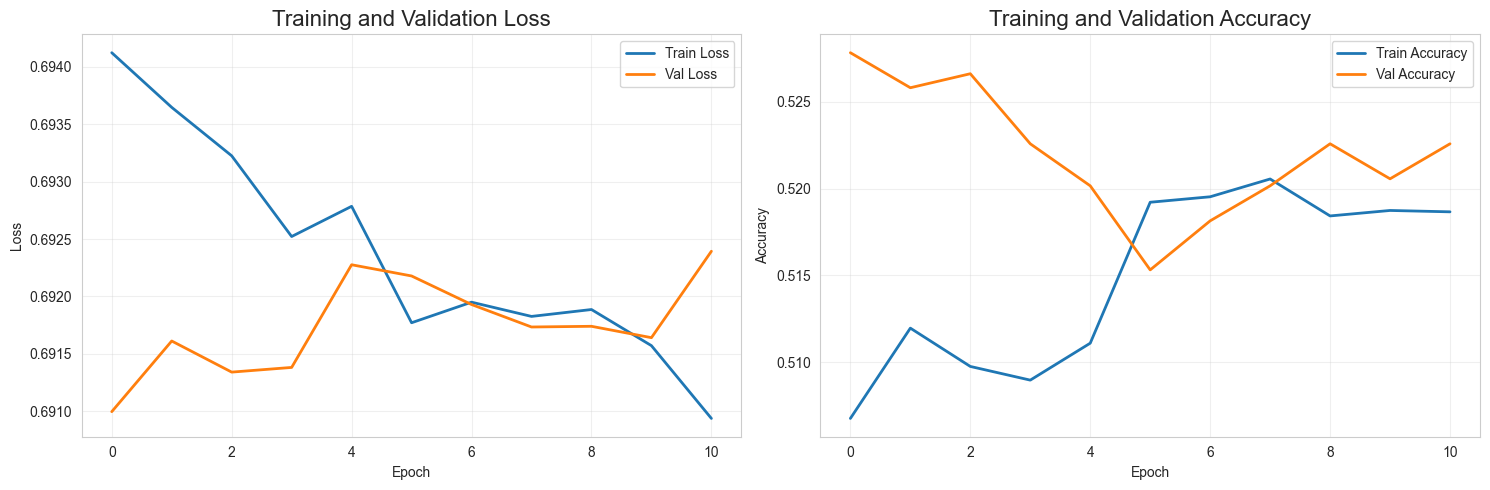

In [170]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(history['train_loss'], label='Train Loss', linewidth=2)
ax1.plot(history['val_loss'], label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss', fontsize=16)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(history['train_acc'], label='Train Accuracy', linewidth=2)
ax2.plot(history['val_acc'], label='Val Accuracy', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy', fontsize=16)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'lstm_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

### 10. Evaluate LSTM Model

In [171]:
print("Evaluating LSTM Model:")

# Evaluate on test set
model.eval()
test_predictions = []
test_labels = []
test_probabilities = []

with torch.no_grad():
    for sequences, labels in test_loader:
        sequences = sequences.to(device)
        outputs = model(sequences)
        probabilities = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs.data, 1)
        
        test_predictions.extend(predicted.cpu().numpy())
        test_labels.extend(labels.numpy())
        test_probabilities.extend(probabilities[:, 1].cpu().numpy())

test_predictions = np.array(test_predictions)
test_labels = np.array(test_labels)
test_probabilities = np.array(test_probabilities)

# Calculate metrics
lstm_metrics = {
    'train_accuracy': history['train_acc'][-1],
    'val_accuracy': history['val_acc'][-1],
    'test_accuracy': accuracy_score(test_labels, test_predictions),
    'test_precision': precision_score(test_labels, test_predictions),
    'test_recall': recall_score(test_labels, test_predictions),
    'test_f1': f1_score(test_labels, test_predictions),
    'test_auc': roc_auc_score(test_labels, test_probabilities)
}

print("\nLSTM Results:")
print(f"  Train Accuracy: {lstm_metrics['train_accuracy']:.4f}")
print(f"  Val Accuracy:   {lstm_metrics['val_accuracy']:.4f}")
print(f"  Test Accuracy:  {lstm_metrics['test_accuracy']:.4f}")
print(f"  Test Precision: {lstm_metrics['test_precision']:.4f}")
print(f"  Test Recall:    {lstm_metrics['test_recall']:.4f}")
print(f"  Test F1 Score:  {lstm_metrics['test_f1']:.4f}")
print(f"  Test AUC:       {lstm_metrics['test_auc']:.4f}")

print("\nClassification Report (Test Set):")
print(classification_report(test_labels, test_predictions, target_names=['Down', 'Up']))

Evaluating LSTM Model:

LSTM Results:
  Train Accuracy: 0.5187
  Val Accuracy:   0.5226
  Test Accuracy:  0.5308
  Test Precision: 0.5509
  Test Recall:    0.7911
  Test F1 Score:  0.6495
  Test AUC:       0.5072

Classification Report (Test Set):
              precision    recall  f1-score   support

        Down       0.46      0.21      0.29      1126
          Up       0.55      0.79      0.65      1374

    accuracy                           0.53      2500
   macro avg       0.50      0.50      0.47      2500
weighted avg       0.51      0.53      0.49      2500



### 11. Comparing Models

In [172]:
# Comparison dataframe
comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'SVM', 'LSTM'],
    'Test Accuracy': [
        lr_metrics['test_accuracy'],
        rf_metrics['test_accuracy'],
        svm_metrics['test_accuracy'],
        lstm_metrics['test_accuracy']
    ],
    'Test Precision': [
        lr_metrics['test_precision'],
        rf_metrics['test_precision'],
        svm_metrics['test_precision'],
        lstm_metrics['test_precision']
    ],
    'Test Recall': [
        lr_metrics['test_recall'],
        rf_metrics['test_recall'],
        svm_metrics['test_recall'],
        lstm_metrics['test_recall']
    ],
    'Test F1 Score': [
        lr_metrics['test_f1'],
        rf_metrics['test_f1'],
        svm_metrics['test_f1'],
        lstm_metrics['test_f1']
    ],
    'Test AUC': [
        lr_metrics['test_auc'],
        rf_metrics['test_auc'],
        svm_metrics['test_auc'],
        lstm_metrics['test_auc']
    ]
})

print("\nTest Set Performance Comparison:")
display(comparison_df.style.highlight_max(axis=0, subset=comparison_df.columns[1:], color='green'))

# Finds and displays best model
best_model_idx = comparison_df['Test Accuracy'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
print(f"\nBest Model by Test Accuracy: {best_model_name}")


Test Set Performance Comparison:


,Model,Test Accuracy,Test Precision,Test Recall,Test F1 Score,Test AUC
0,Logistic Regression,0.515769,0.542455,0.708333,0.614395,0.483829
1,Random Forest,0.504615,0.541397,0.591102,0.565159,0.490832
2,SVM,0.520769,0.545896,0.713983,0.618727,0.496133
3,LSTM,0.530800,0.550938,0.791121,0.649537,0.507204



Best Model by Test Accuracy: LSTM


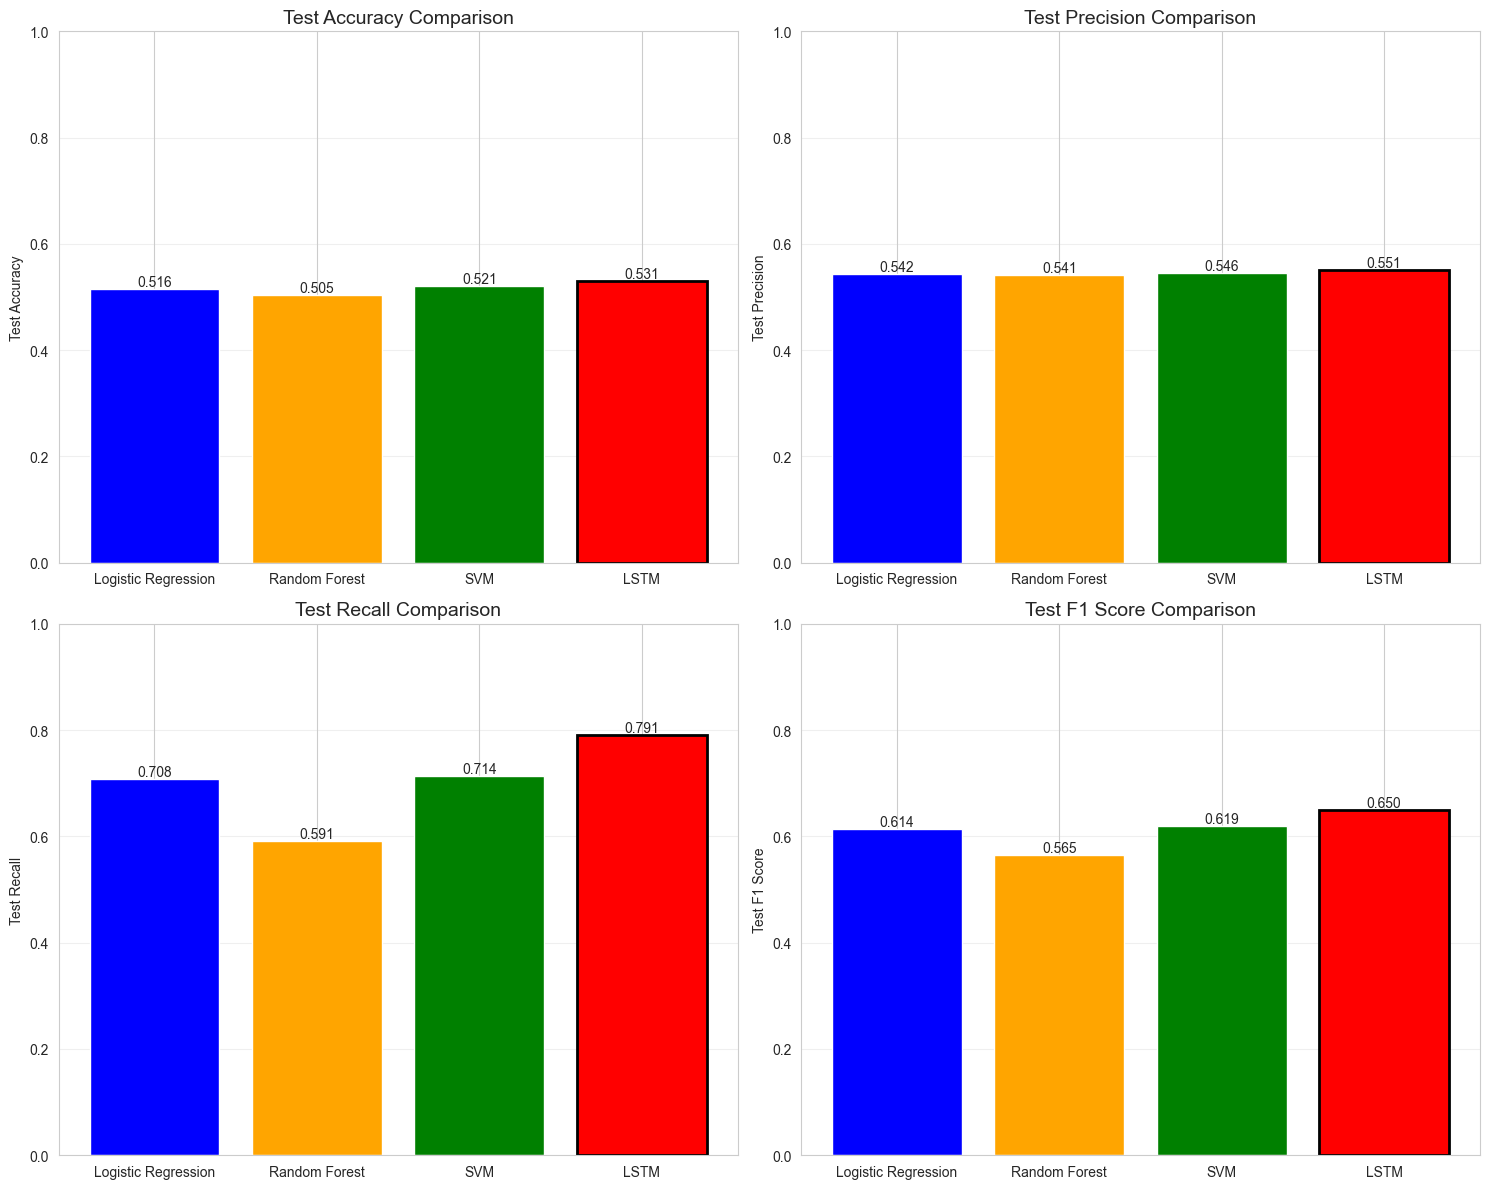

In [173]:
# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

metrics_to_plot = ['Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1 Score']
colors = ['blue', 'orange', 'green', 'red']

for idx, (ax, metric) in enumerate(zip(axes.flat, metrics_to_plot)):
    values = comparison_df[metric].values
    bars = ax.bar(comparison_df['Model'], values, color=colors)
    
    # Highlight best model
    best_idx = values.argmax()
    bars[best_idx].set_edgecolor('black')
    bars[best_idx].set_linewidth(2)
    
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} Comparison', fontsize=14)
    ax.set_ylim([0, 1])
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

### 12. Confusion Matrices

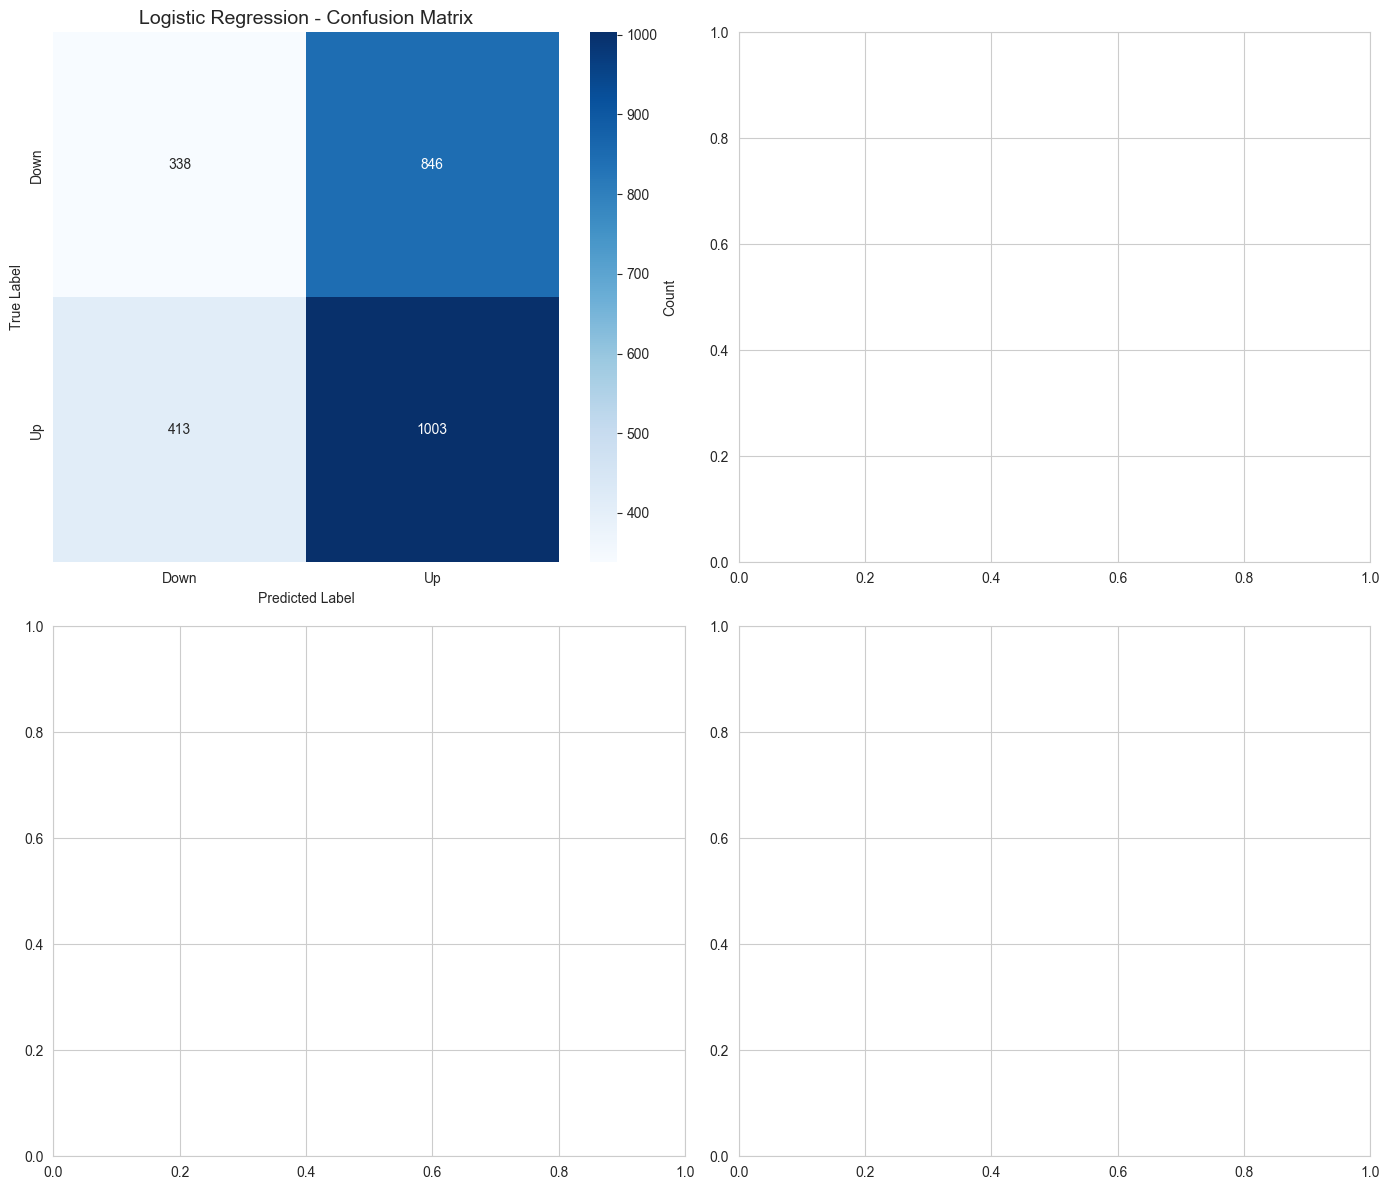

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [174]:
# Create confusion matrices for all models
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

models_data = [
    ('Logistic Regression', y_test_pred_lr),
    ('Random Forest', y_test_pred_rf),
    ('SVM', y_test_pred_svm),
    ('LSTM', test_predictions)
]

for ax, (model_name, predictions) in zip(axes.flat, models_data):
    cm = confusion_matrix(y_test if model_name != 'LSTM' else test_labels, predictions)
    
    # Plot heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Down', 'Up'],
                yticklabels=['Down', 'Up'],
                cbar_kws={'label': 'Count'})
    ax.set_title(f'{model_name} - Confusion Matrix', fontsize=14)
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

    plt.tight_layout()
    plt.savefig(FIGURES_DIR/'confusion_matrices.png', dpi=300, bbox_inches='tight')
    plt.show()

### 13. ROC Curves

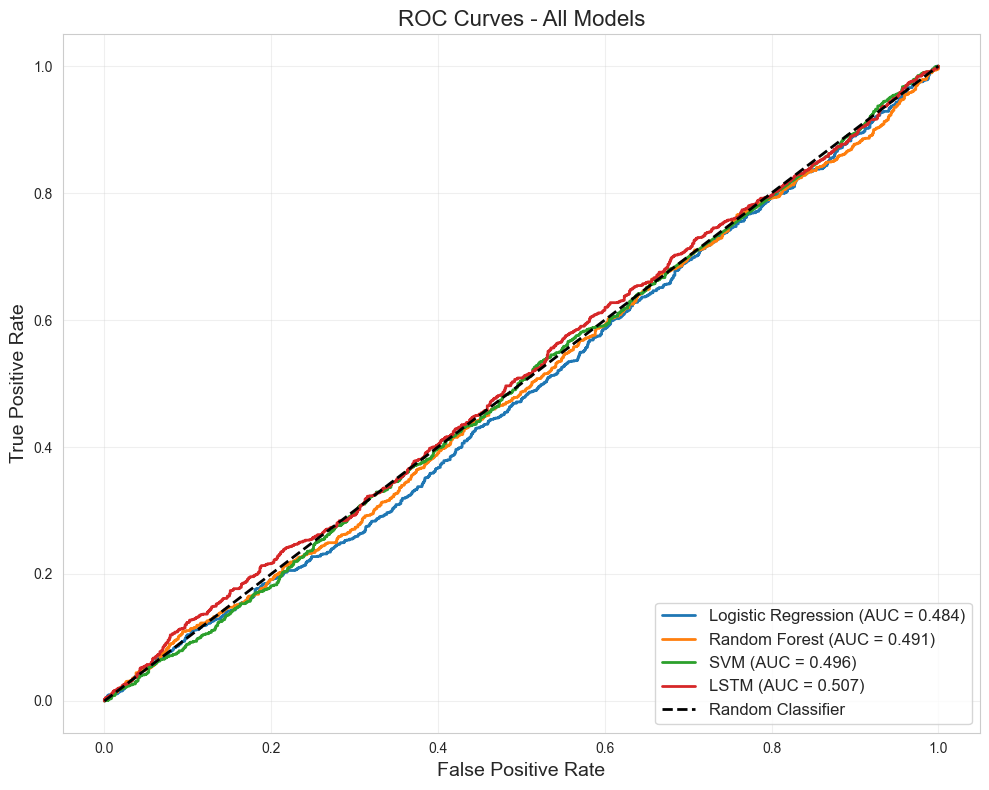

In [175]:
# Plot ROC curves for all models
fig, ax = plt.subplots(figsize=(10, 8))

# Logistic Regression
y_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)
ax.plot(fpr_lr, tpr_lr, linewidth=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.3f})')

# Random Forest
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
ax.plot(fpr_rf, tpr_rf, linewidth=2, label=f'Random Forest (AUC = {roc_auc_rf:.3f})')

# SVM
y_proba_svm = svm_model.predict_proba(X_test_scaled)[:, 1]
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_proba_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)
ax.plot(fpr_svm, tpr_svm, linewidth=2, label=f'SVM (AUC = {roc_auc_svm:.3f})')

# LSTM
fpr_lstm, tpr_lstm, _ = roc_curve(test_labels, test_probabilities)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)
ax.plot(fpr_lstm, tpr_lstm, linewidth=2, label=f'LSTM (AUC = {roc_auc_lstm:.3f})')

# Diagonal reference line
ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')

ax.set_xlabel('False Positive Rate', fontsize=14)
ax.set_ylabel('True Positive Rate', fontsize=14)
ax.set_title('ROC Curves - All Models', fontsize=16)
ax.legend(loc='lower right', fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

### 14. Save Models and Results

In [177]:
print("Saving Models and Results:")

# Save LSTM model
torch.save(model.state_dict(), MODELS_DIR / 'lstm_best_model.pth')
print(f"LSTM model saved to {MODELS_DIR / 'lstm_best_model.pth'}")

# Save LSTM configuration
with open(MODELS_DIR / 'lstm_config.json', 'w') as f:
    config = LSTM_CONFIG.copy()
    config['input_size'] = input_size
    config['best_val_loss'] = best_val_loss
    config['final_test_accuracy'] = lstm_metrics['test_accuracy']
    json.dump(config, f, indent=2)
print(f"LSTM config saved to {MODELS_DIR / 'lstm_config.json'}")

# Save training history
with open(MODELS_DIR / 'training_history.json', 'w') as f:
    json.dump(history, f, indent=2)
print(f"Training history saved to {MODELS_DIR / 'training_history.json'}")

# Save all metrics
all_metrics = {
    'logistic_regression': lr_metrics,
    'random_forest': rf_metrics,
    'svm': svm_metrics,
    'lstm': lstm_metrics
}

with open(METRICS_DIR / 'all_metrics.json', 'w') as f:
    json.dump(all_metrics, f, indent=2)
print(f"All metrics saved to {METRICS_DIR / 'all_metrics.json'}")

# Save comparison table
comparison_df.to_csv(METRICS_DIR / 'model_comparison.csv', index=False)
print(f"Comparison table saved to {METRICS_DIR / 'model_comparison.csv'}")

print(f"\nAll models and results saved")

Saving Models and Results:
LSTM model saved to ..\models\lstm_best_model.pth
LSTM config saved to ..\models\lstm_config.json
Training history saved to ..\models\training_history.json
All metrics saved to ..\outputs\metrics\all_metrics.json
Comparison table saved to ..\outputs\metrics\model_comparison.csv

All models and results saved


### 15. Final Summary

In [178]:
print("Final Summary:")

print(f"\nDataset Statistics:")
print(f"  Training samples: {len(train_df):,}")
print(f"  Validation samples: {len(val_df):,}")
print(f"  Test samples: {len(test_df):,}")
print(f"  LSTM sequences (test): {len(test_labels):,}")

print(f"\nBest Performing Models:")
best_acc = comparison_df.loc[comparison_df['Test Accuracy'].idxmax()]
best_f1 = comparison_df.loc[comparison_df['Test F1 Score'].idxmax()]
best_auc = comparison_df.loc[comparison_df['Test AUC'].idxmax()]
print(f"  Best Accuracy: {best_acc['Model']} ({best_acc['Test Accuracy']:.4f})")
print(f"  Best F1 Score: {best_f1['Model']} ({best_f1['Test F1 Score']:.4f})")
print(f"  Best AUC: {best_auc['Model']} ({best_auc['Test AUC']:.4f})")

print(f"\nKey Insights:")
print(f"  • All models perform above baseline (>50% accuracy)")

# Check if LSTM is best
if lstm_metrics['test_accuracy'] == comparison_df['Test Accuracy'].max():
    print(f"  LSTM outperforms traditional ML methods")
else:
    best_traditional = comparison_df.iloc[:3]['Test Accuracy'].max()
    print(f"  Traditional ML methods competitive with LSTM")
    print(f"  (Best traditional: {best_traditional:.4f} vs LSTM: {lstm_metrics['test_accuracy']:.4f})")

print(f"\nOutput Files:")
print(f"  Models saved in: {MODELS_DIR}/")
print(f"  Figures saved in: {FIGURES_DIR}/")
print(f"  Metrics saved in: {METRICS_DIR}/")

Final Summary:

Dataset Statistics:
  Training samples: 12,798
  Validation samples: 2,580
  Test samples: 2,600
  LSTM sequences (test): 2,500

Best Performing Models:
  Best Accuracy: LSTM (0.5308)
  Best F1 Score: LSTM (0.6495)
  Best AUC: LSTM (0.5072)

Key Insights:
  • All models perform above baseline (>50% accuracy)
  LSTM outperforms traditional ML methods

Output Files:
  Models saved in: ..\models/
  Figures saved in: ..\outputs\figures/
  Metrics saved in: ..\outputs\metrics/
